In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [37]:
config = Dataset_load.load_config()
colors = config['colors']['one']

In [159]:
colors

['mediumvioletred', 'midnightblue', 'palevioletred', 'cornflowerblue']

In [5]:
livetimes = np.logspace(0, 2,  7)
print(livetimes)

[  1.           2.15443469   4.64158883  10.          21.5443469
  46.41588834 100.        ]


In [6]:
%%time
scaled_amplitude = Parameter('amplitude', 
                             value = 1e-12)
datasets_asimov = []
for l in livetimes:
    dataset_asimov_2  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                                   livetime = f"{l}-hr",
                                            parameters = Parameters([scaled_amplitude]))
    datasets_asimov.append(dataset_asimov_2)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-4.641588833612778-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-10.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-21.544346900318832-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-46.41588833612777-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-100.0-hr.fits.gz
CPU times: user 42.4 s, sys: 1.93 s, total: 44.3 s
Wall time: 44.4 s


In [7]:
dataset_asimov  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                            parameters = Parameters([scaled_amplitude]))

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


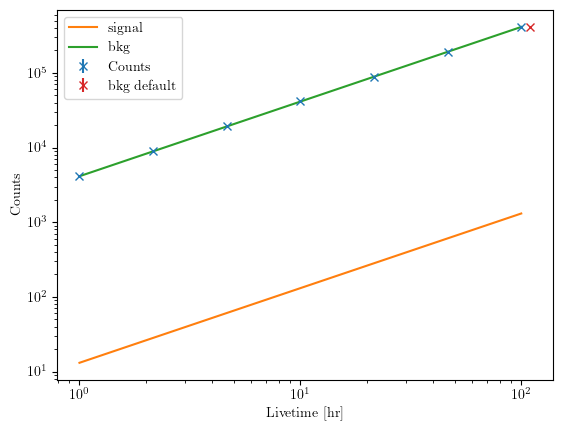

In [8]:
counts, signal, bkg = [] , [], []
for d in datasets_asimov:
    counts.append(d.counts.data.sum())
    signal.append(d.npred_signal().data.sum())
    bkg.append(d.npred_background().data.sum())
    
    
plt.errorbar(livetimes, counts, yerr = np.sqrt(counts), fmt= 'x', label = "Counts")
plt.plot(livetimes, signal, label = "signal")
plt.plot(livetimes, bkg, label = "bkg")
counts = dataset_asimov.counts.data.sum() 

plt.errorbar(110,counts, yerr = np.sqrt(counts) , fmt= 'x', label = "bkg default")


plt.loglog()
plt.xlabel("Livetime [hr]")
plt.ylabel("Counts")
plt.legend()

## Datasets

In [9]:
true_energy = datasets_asimov[0].exposure.geom.axes[0].center.value



shift_as = 0.1
tilt_as = 0.015
bias_as, resolution_as = 0.1,0.1
bkg_norm_as, bkg_tilt_as = 0.1, 0.02



In [115]:
datasets_N = []
datasets_N_H0 = []

for d in datasets_asimov:
    sys_d_cor = sys_dataset(dataset_asimov= d,
                        shift = 0., 
                        tilt = 0.,
                        bias = 0.,
                        resolution = 0.,
                        bkg_norm = 0., 
                        bkg_tilt = 0., 
                        rnd = False,
                        e_reco_creation=100)
    dataset_cor_N = sys_d_cor.create_dataset_N(100)
    dataset_cor_N.background_model.parameters['tilt_nuisance'].frozen = False
    dataset_cor_N.irf_model.parameters['tilt_nuisance'].frozen = False
    datasets_N.append(dataset_cor_N)
    dataset_cor_N = sys_d_cor.create_dataset_N(100)
    dataset_cor_N.background_model.parameters['tilt_nuisance'].frozen = False
    dataset_cor_N.irf_model.parameters['tilt_nuisance'].frozen = False
    datasets_N_H0.append(dataset_cor_N)
        

npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


In [117]:
print(datasets_N_H0[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    ref

In [119]:
zero = 1e-24

## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((6, 6))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/bkg_norm_as ** 2, 1/ bkg_tilt_as**2 ,1/bias_as**2, 1/resolution_as**2, 1/shift_as**2, 1/tilt_as**2, ])
for i in range(len(datasets_N)):
    datasets_N[i].penalising_invcovmatrix = penalising_invcovmatrix
for i in range(len(datasets_N_H0)):
    datasets_N_H0[i].penalising_invcovmatrix = penalising_invcovmatrix


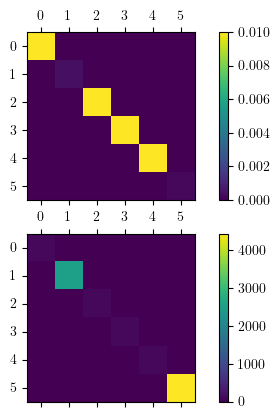

In [12]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)

from numpy.linalg import inv
penalising_covmatrix = inv(penalising_invcovmatrix)

cax = ax[0].matshow(penalising_covmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

[]

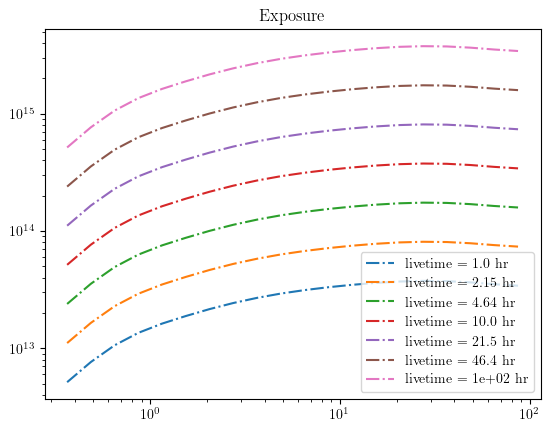

In [13]:
emask = dataset_cor_N.mask.data.sum(axis=2).sum(axis=1) >0 

e_bins = dataset_cor_N.geoms['geom'].axes[0].center.value[emask]

true_energy = dataset_cor_N.exposure.geom.axes[0].center.value[emask]
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)[emask]

for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.exposure.data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Exposure")
plt.legend()
plt.loglog()

npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp
npred_edisp


[]

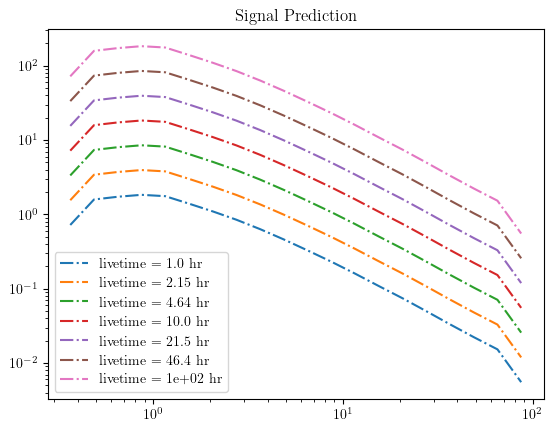

In [14]:
npred = []
for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.npred_signal().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')
    npred.append(d.npred_signal().data.sum())
plt.title("Signal Prediction")
plt.legend()
plt.loglog()



[]

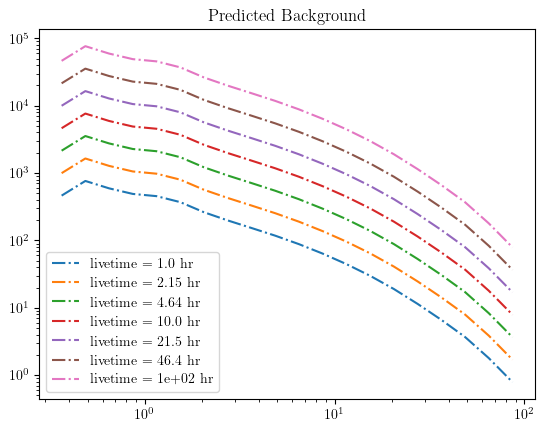

In [133]:
for i, d in enumerate(datasets_N):
    plt.plot(e_bins,sum_e(d.npred_background().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Predicted Background")

plt.legend()
plt.loglog()

In [134]:
%%time
fitting = 0


if fitting:
    for i, d in enumerate(datasets_N):
        print(i)
        fit_cor = Fit(store_trace=True)
        result_cor = fit_cor.run(d)
        print(result_cor)
        d.models.covariance = fit_cor.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print("saving")
        path = f'data/8_model_nui_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets_N):
        path = f'data/8_model_nui_livetime_{livetimes[i]}.yml'
        datasets_N[i] = Dataset_load.load_dataset_N(d, path,bkg_sys = True)        
        datasets_N[i].models.parameters['tilt_nuisance'].frozen = False 
    

#39min 32

read
CPU times: user 734 ms, sys: 226 ms, total: 960 ms
Wall time: 972 ms


In [135]:
print("read")
datasets = []
for i, d in enumerate(datasets_N):
    path = f'data/8_model_livetime_{livetimes[i]}.yml'
    da = Dataset_load.load_dataset(d, path)     
    datasets.append(da)

read


In [136]:
colors

['mediumvioletred', 'midnightblue', 'palevioletred', 'cornflowerblue']

In [137]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6, color = 'red'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label, color = color)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            #try:
            plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j], 
                        color = colors_default [j])
            #except:
            #    pass

    plt.tight_layout()
    return fig

fmts = ['o','x', '*']*3
markersize = [6,10, 10] * 3

In [138]:
labels = [str(int(l)) for l in livetimes]
colors_default =  plt.rcParams['axes.prop_cycle'].by_key()['color']

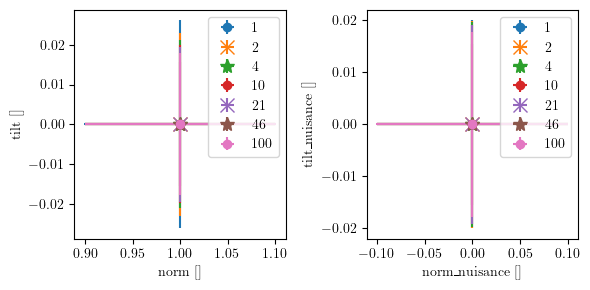

In [139]:
models_list = [ d.background_model for d in datasets_N]
pars =   [('norm', 'tilt'), ('norm_nuisance', 'tilt_nuisance')]
fig = plot_source_par(0, pars)


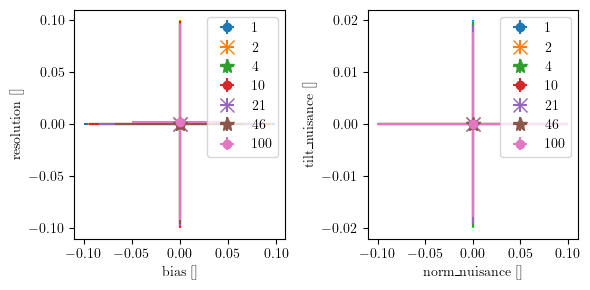

In [140]:
models_list = [ d.irf_model for d in datasets_N]
pars =   [('bias', 'resolution'), ('norm_nuisance', 'tilt_nuisance')]
fig = plot_source_par(0, pars)

(-0.01, 0.2)

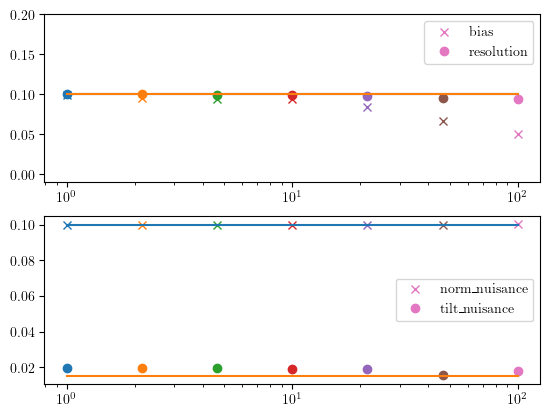

In [141]:
i = 0
fig,axs = plt.subplots(2,1)
for l, m in zip(livetimes, models_list):
    axs[0].plot(l, m.parameters[pars[0][0]].error, 'x', label = "bias", color = colors_default[i])
    axs[0].plot(l, m.parameters[pars[0][1]].error, 'o' , label = "resolution", color = colors_default[i])
    axs[1].plot(l, m.parameters[pars[1][0]].error, 'x' , label = "norm_nuisance", color = colors_default[i])
    axs[1].plot(l, m.parameters[pars[1][1]].error, 'o' , label = "tilt_nuisance", color = colors_default[i])
    i +=1
    
axs[0].plot([livetimes[0],livetimes[-1]], [bias_as, bias_as])
axs[0].plot([livetimes[0],livetimes[-1]], [resolution_as, resolution_as])
axs[1].plot([livetimes[0],livetimes[-1]], [shift_as, shift_as])
axs[1].plot([livetimes[0],livetimes[-1]], [tilt_as, tilt_as])  

for a in axs:
    a.set_xscale("log")
    a.legend()


    from collections import OrderedDict

    handles, labels = a.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys())
    
axs[0].set_ylim(-0.01, 0.2)

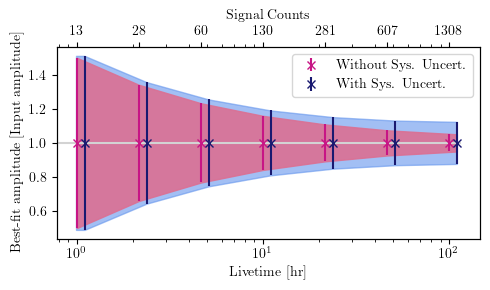

In [162]:
inputvalues = {"amplitude":1e-12, "index":2.3}
def plotting(parname = "amplitude"):
    fig = plt.figure(figsize  = (5,3))
    inputvalue = inputvalues[parname]
    
    errs = []
    errs_N = []
    livetimes_ext = livetimes.copy(); livetimes_ext2 = livetimes.copy(); 
    livetimes_ext[-1] *=1.1;
    livetimes_ext2[0:,] *=1.1; 
    livetimes_ext2 = np.insert(livetimes_ext2, 0, values =  livetimes_ext2[0]* 0.9)


    for i, d in enumerate(datasets_N):
        par = datasets[i].models[0].parameters[parname]
        val, err = par.value, par.error
        errs.append( err/ inputvalue)
        plt.errorbar(livetimes[i], val/ inputvalue, yerr = err/ inputvalue,  fmt='x', 
                     color = colors[0])

        par = d.models[0].parameters[parname]
        val, err = par.value, par.error
        errs_N.append( err/ inputvalue)
        plt.errorbar( 1.1* livetimes[i] , val/ inputvalue, yerr = err/ inputvalue,  fmt='x', 
                     color = colors[1])

    

    errs_N = np.insert(errs_N, 0, values =  errs_N[0])
    plt.fill_between(  livetimes_ext2, 1- np.array(errs_N), 1+np.array(errs_N) ,color = colors[3], alpha = 0.6, label = '')
    plt.fill_between( livetimes_ext, 1- np.array(errs), 1+np.array(errs) ,color = colors[2], alpha = 0.9, label = '')

    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[0], label = 'Without Sys. Uncert.')
    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = colors[1], label = 'With Sys. Uncert.')
    ax1 = plt.gca()
    xlim = ax1.get_xlim()
    plt.hlines(1, xlim[0], xlim[1], color = 'lightgrey')
    #plt.title("Best Fit Amplitude")
    plt.legend()
    plt.xscale('log')
    plt.xlabel("Livetime [hr]")
    plt.ylabel(f"Best-fit {parname} [Input {parname}]")

    ax2 = ax1.twiny()
    ax2.set_xscale("log")

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(livetimes)
    clabels = [ f'{int(c)}' for c in npred]
    ax2.set_xticklabels(clabels)
    ax2.set_xlabel(r"Signal Counts")
    plt.tight_layout()
    return fig

fig = plotting(parname = "amplitude")
fig.savefig('plots/8_best_fit_vs_livetime.svg')
fig.savefig('plots/8_best_fit_vs_livetime.pdf')
fig.savefig('plots/8_best_fit_vs_livetime.png')

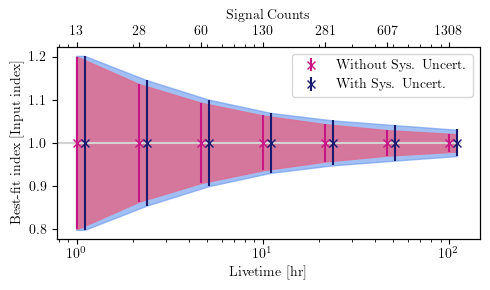

In [163]:
fg = plotting("index")

## Significance

In [127]:
%%time
fitting = 0
if fitting:
    for i, d in enumerate(datasets_N_H0):
        print(i)
        datasets_N_H0[i].models.parameters['amplitude'].value = 1e-24
        datasets_N_H0[i].models.parameters['amplitude'].frozen  = True
        
        datasets_N_H0[i].models[0].parameters.freeze_all()
        print("pre fit" , datasets_N_H0[i])
        fit_cor = Fit()
        result_cor = fit_cor.run(d)
        print(result_cor)
        
        print("post" , datasets_N_H0[i])
        
        
        print("saving")
        path = f'data/8_model_nui_H0_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
else:
    print("read")
    for i, d in enumerate(datasets_N_H0):
        path = f'data/8_model_nui_H0_livetime_{livetimes[i]}.yml'
        datasets_N_H0[i]= Dataset_load.load_dataset_N(d, path, bkg_sys = True)
        datasets_N_H0[i].penalising_invcovmatrix = penalising_invcovmatrix



0
pre fit MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 4145 
  Total background counts         : 4132.38
  Total excess counts             : 13.09

  Predicted counts                : 4132.38
  Predicted background counts     : 4132.38
  Predicted excess counts         : 0.00

  Exposure min                    : 1.57e-27 m2 s
  Exposure max                    : 1.27e+09 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 942469 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 46691.51

  Number of models                : 3 
  Number of parameters            : 16
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : aEaZD8Bs
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      i

In [128]:
datasets_H0 = []
print("read")
for i, d in enumerate(datasets_N):
    path = f'data/8_model_H0_livetime_{livetimes[i]}.yml'
    datasets_H0.append(Dataset_load.load_dataset(d, path))

read


In [129]:
sig , sig_N = [], []
for i, l in enumerate(livetimes):
    print()
    print(l)
    H0 = datasets_H0[i].stat_sum()
    H1 = datasets[i].stat_sum()
    print("HO", H0)
    print("H1", H1)
    
    sig.append(np.sqrt(np.abs(H0- H1)))
    print("sig", sig)
    
    H0 = datasets_N_H0[i].stat_sum()
    H1 = datasets_N[i].stat_sum()
    sig_N.append(np.sqrt(np.abs(H0- H1)))
    print("HO", H0)
    print("H1", H1)
    print("sig_N", sig_N)
    


1.0
HO 46691.28544699188
H1 46683.109677414184
sig [2.8593302673349563]
HO 46691.4627165811
H1 46683.10970554684
sig_N [2.8901576140864234]

2.154434690031884
HO 86883.50139946004
H1 86865.88729553371
sig [2.8593302673349563, 4.196916001819807]
HO 86883.88306153439
H1 86865.8873568692
sig_N [2.8901576140864234, 4.242134446853782]

4.641588833612778
HO 157647.9097954074
H1 157609.96134320687
sig [2.8593302673349563, 4.196916001819807, 6.160231505433611]
HO 157648.73160029235
H1 157609.96147650058
sig_N [2.8901576140864234, 4.242134446853782, 6.226565971044111]

10.0
HO 276006.7616795867
H1 275925.0039345103
sig [2.8593302673349563, 4.196916001819807, 6.160231505433611, 9.04199895357418]
HO 276008.5313657433
H1 275925.00422154757
sig_N [2.8901576140864234, 4.242134446853782, 6.226565971044111, 9.139318584869704]

21.544346900318832
HO 457540.3044602036
H1 457364.1640155948
sig [2.8593302673349563, 4.196916001819807, 6.160231505433611, 9.04199895357418, 13.271791311228966]
HO 457544.1177

Text(0, 0.5, 'Significance')

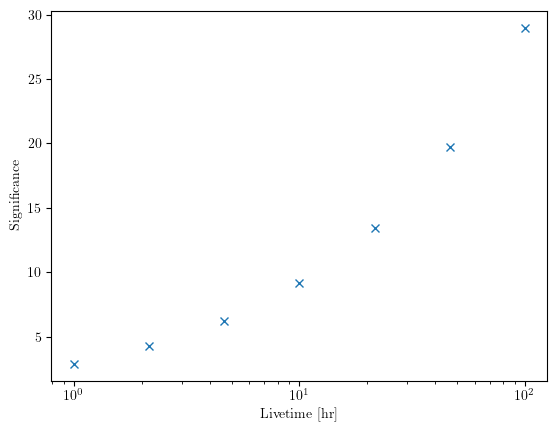

In [125]:
plt.plot(livetimes, sig_N, 'x')
plt.xscale("log")
plt.xlabel("Livetime [hr]")
plt.ylabel("Significance")


Text(0, 0.5, 'Significance')

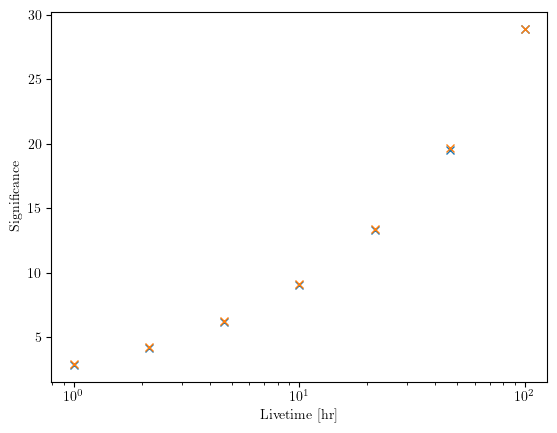

In [130]:
plt.plot(livetimes, sig, 'x')

plt.plot(livetimes, sig_N, 'x')

plt.xscale("log")
plt.xlabel("Livetime [hr]")
plt.ylabel("Significance")


## Correlation Matrices

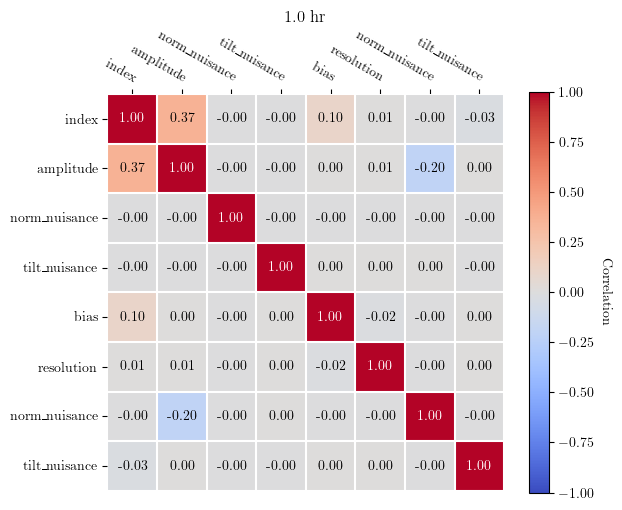

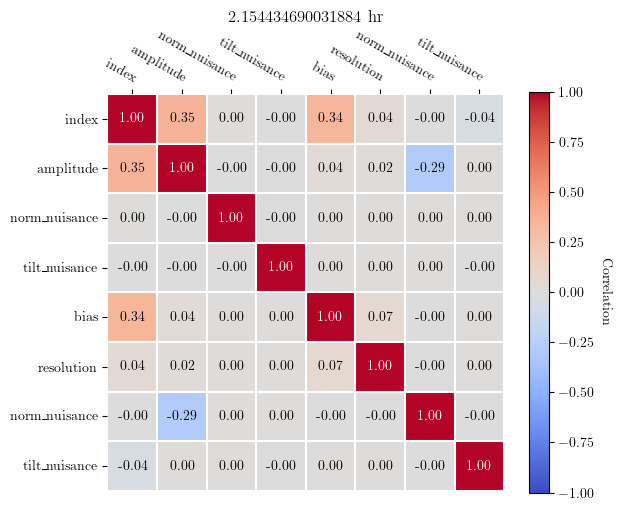

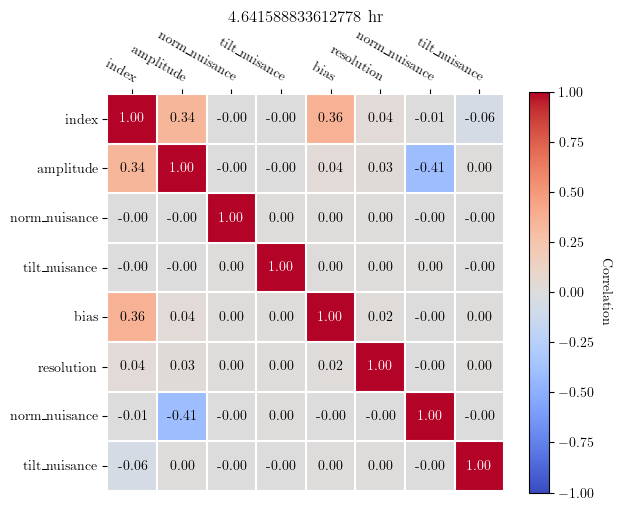

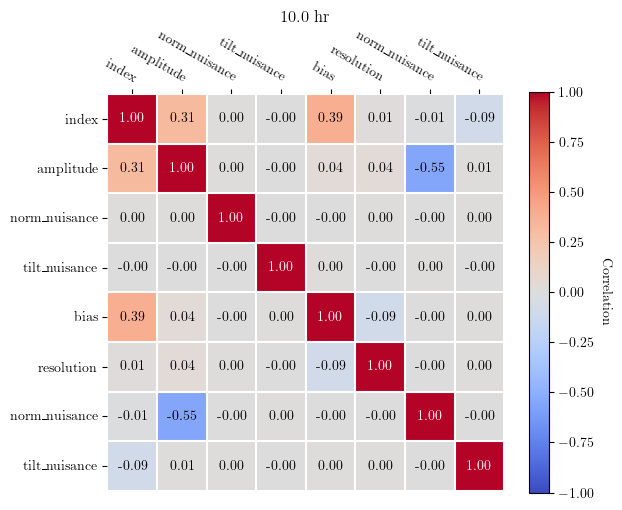

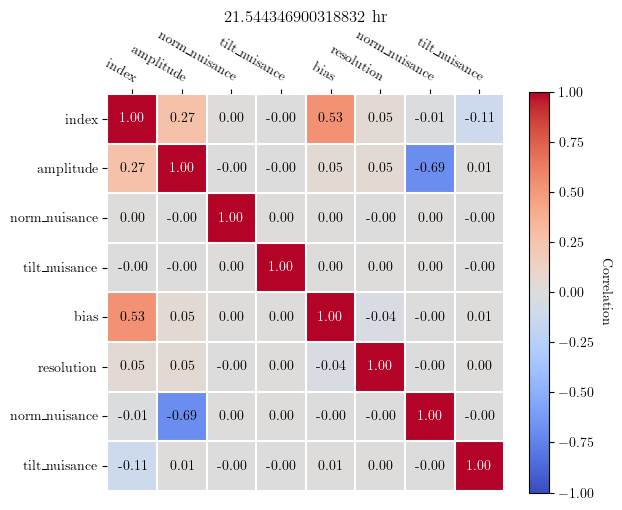

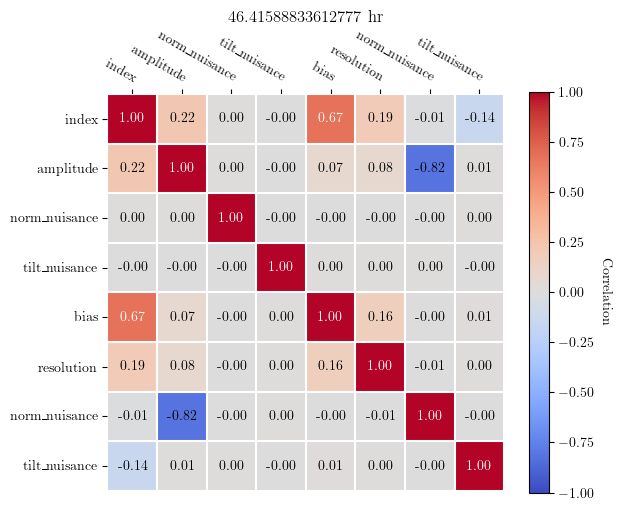

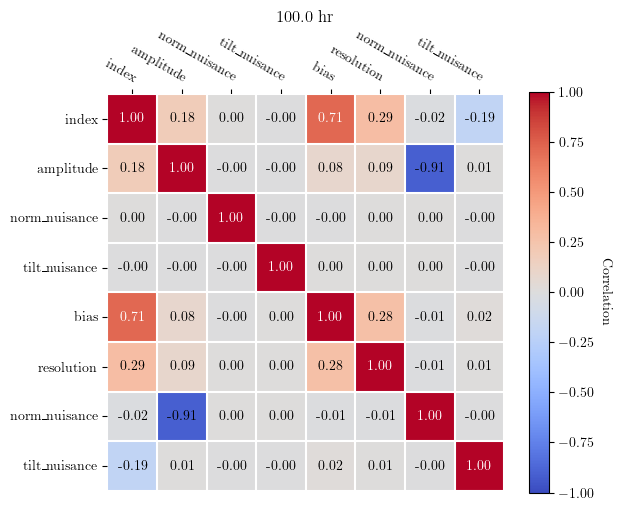

In [158]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm_nuisance' , 
            'tilt_nuisance']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
for i in range(len(livetimes)):

    datasets_N[i].models.read_covariance("data", f"8_model_nui_livetime_{livetimes[i]}_covariance.dat", format="ascii.fixed_width")
    parameters = Parameters([_ for _ in datasets_N[i].models.parameters if _.name in par_names])
    cov_par = datasets_N[i].models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    ax.set_title(str(livetimes[i]) + " hr")
    fig = plt.gcf()
    fig.savefig(f"plots/8_covmatrix_livetime_{livetimes[i]}.svg")
    fig.savefig(f"plots/8_covmatrix_livetime_{livetimes[i]}.pdf")
    
